In [55]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import f1_score,roc_auc_score

### The purpose of this script is to debug -- to prove that the sigmoid function is working properly, which means the problem of predicting all same class is not due to the last layer

### simulate y = sigmoid(x) with x with mean of 0 and variance of 4 

In [35]:
np.random.seed(10)
num_observations = 10000
x1 = np.random.normal(loc = 0.0, scale =4.0,  size =num_observations)
y = 1 / (1 + np.exp(-x1))

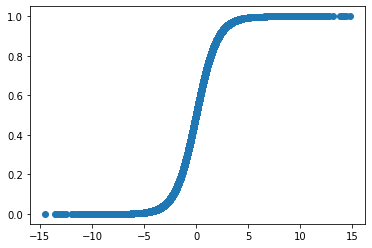

In [36]:
plt.figure() # Create a new figure, or activate an existing figure.
plt.scatter(x1,y) # make scatter plot
plt.show()

In [37]:
# convert y <0.5 to 0 and y >=0.5 to 1
y = [1 if num <0.5 else 0 for num in y ]
print(f"there are {y.count(0)} sample as 0 and {y.count(1)} sample as 1")

there are 5054 sample as 0 and 4946 sample as 1


#### sample 3:1 case control ratio for training and validation set

In [38]:
ones_idx = [i for i, e in enumerate(y) if e == 1]
zeros_idx = [i for i, e in enumerate(y) if e == 0]
train_ones_idx = ones_idx[:4000]
val_ones_idx = ones_idx[4000:4800]
train_zero_idx = zeros_idx[:1500]
val_zero_idx = zeros_idx[1500:3000]
train = np.vstack([([[x1[i] for i in train_ones_idx]+ [x1[i] for i in train_zero_idx]]), 
                   ([[y[i] for i in train_ones_idx]+[y[i] for i in train_zero_idx]])])
val = np.vstack([([[x1[i] for i in val_ones_idx]+ [x1[i] for i in val_zero_idx]]), 
                   ([[y[i] for i in val_ones_idx]+[y[i] for i in val_zero_idx]])])
print(train.shape, val.shape)

(2, 5500) (2, 2300)


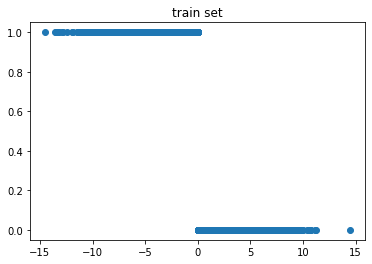

In [39]:
# plot train and val 
plt.figure() # Create a new figure, or activate an existing figure.
plt.scatter(train[0],train[1]) # make scatter plot
plt.title("train set")
plt.show()

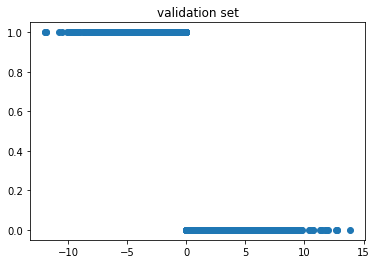

In [40]:
# plot train and val 
plt.figure() # Create a new figure, or activate an existing figure.
plt.scatter(val[0],val[1]) # make scatter plot
plt.title("validation set")
plt.show()

In [41]:
print(f"training set before shuffle is {train.T}")
print(f"val set before shuffle is {val.T}")

training set before shuffle is [[-6.18160117  1.        ]
 [-0.0335354   1.        ]
 [-2.88034224  1.        ]
 ...
 [ 1.42074394  0.        ]
 [ 2.9530874   0.        ]
 [ 1.52372099  0.        ]]
val set before shuffle is [[-2.65575987  1.        ]
 [-1.96951963  1.        ]
 [-3.68654686  1.        ]
 ...
 [ 0.1722922   0.        ]
 [ 1.40488578  0.        ]
 [ 1.74993621  0.        ]]


In [42]:
# shuffle rows of train and val so that case and controls are distributed evenly 
np.random.shuffle(train.T) # it will shuffle in place
np.random.shuffle(val.T)

In [43]:
print(f"training set after shuffle is {train.T}")
print(f"val set after shuffle is {val.T}")

training set after shuffle is [[ 2.05627978  0.        ]
 [-1.92888618  1.        ]
 [ 4.3824302   0.        ]
 ...
 [ 9.59125577  0.        ]
 [-1.9159139   1.        ]
 [-0.63539567  1.        ]]
val set after shuffle is [[11.701297    0.        ]
 [ 4.42001316  0.        ]
 [ 6.73196352  0.        ]
 ...
 [ 3.14784748  0.        ]
 [ 3.68882897  0.        ]
 [-4.23892954  1.        ]]


### train a logistic regression for outcome prediction

In [44]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim )

    def forward(self, input_dim):
        outputs = torch.sigmoid(self.linear(input_dim))
        return outputs

In [45]:
model = LogisticRegression(len(train[0]),len(train[0]))
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [72]:
print(train[1].tolist().count(0),train[1].tolist().count(1))

1500 4000


### See if the model is able to predict 2 classes

In [75]:
for epoch in range(100):
        total_loss = 0.0
        total_f1 = 0.0
        total_auc = 0.0
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()


        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        # torch.stack convert input to tensor, and transpose it to (batch_size, padded_len), torch.LongTensor convert to intabs
        true_target = torch.from_numpy(train[1]).float() #torch.FloatTensor is the default type
        
        #print(f"true target shape is {true_target.shape}")
        
        # Step 3. Run our forward pass.
        pred_target = model(torch.from_numpy(train[0]).float())
        #print(pred_target)
        #print(f"pred target shape is {pred_target.shape}")
        #print(padded_peptide_in)
        
        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = torch.nn.functional.binary_cross_entropy(pred_target, true_target)
        
        #print(f"target shapes are {pred_target.shape, true_target.shape}")
        # Step 5. compute accuracy
        pred_binary = (pred_target > 0.5).type(torch.FloatTensor)
        
        print(f"1.0 have these many {pred_binary.tolist().count(1.0)}, 0.0 have these many {pred_binary.tolist().count(0.0)}" )
        f1 = f1_score(true_target, pred_binary, average = 'weighted')
        auc = roc_auc_score(true_target, pred_binary, average = 'weighted')
        
        loss.backward()
        #optimizer.step is performs a parameter update based on the current gradient (stored in .grad attribute of a parameter) and the update rule.
        optimizer.step()
        #The item() method extracts the loss’s value as a Python float.
        total_loss +=loss.item()
        total_f1 += f1
        total_auc += auc
        

1.0 have these many 3268, 0.0 have these many 2232
1.0 have these many 3274, 0.0 have these many 2226
1.0 have these many 3279, 0.0 have these many 2221
1.0 have these many 3282, 0.0 have these many 2218
1.0 have these many 3282, 0.0 have these many 2218
1.0 have these many 3289, 0.0 have these many 2211
1.0 have these many 3288, 0.0 have these many 2212
1.0 have these many 3292, 0.0 have these many 2208
1.0 have these many 3298, 0.0 have these many 2202
1.0 have these many 3298, 0.0 have these many 2202
1.0 have these many 3304, 0.0 have these many 2196
1.0 have these many 3311, 0.0 have these many 2189
1.0 have these many 3321, 0.0 have these many 2179
1.0 have these many 3327, 0.0 have these many 2173
1.0 have these many 3337, 0.0 have these many 2163
1.0 have these many 3342, 0.0 have these many 2158
1.0 have these many 3353, 0.0 have these many 2147
1.0 have these many 3357, 0.0 have these many 2143
1.0 have these many 3358, 0.0 have these many 2142
1.0 have these many 3361, 0.0 h

#### Yes, it can!